# Rendu Olivier PERDRIX

## Importations

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

## Génération du dataset

In [202]:
# Paramètres du dataset
num_rows = 10000
cities = ["Paris", "Lyon", "Marseille"]
csv_apartment = "../backend/data/apartments.csv"

def generate_realistic_price(city, area, balcony_value, garage_value, year_of_construction):
    # Ajustement basé sur l'année de construction (les appartements plus récents sont plus chers)
    year_factor = 1 + (year_of_construction - 2005) * 0.02  # 2% d'augmentation par an
    
    # Prix moyens basés sur les données du marché
    if city == "Paris":
        base_price = np.random.normal(9259, 1500) * area  # Prix moyen de 9 259 €/m² à Paris, écart-type ajusté
        balcony_bonus = 6000 * balcony_value
        garage_bonus = 12000 * garage_value
    elif city == "Lyon":
        base_price = np.random.normal(4827, 1000) * area  # Prix moyen de 4 827 €/m² à Lyon
        balcony_bonus = 4000 * balcony_value
        garage_bonus = 8000 * garage_value
    else:  # Marseille
        base_price = np.random.normal(3662, 800) * area  # Prix moyen de 3 662 €/m² à Marseille
        balcony_bonus = 3000 * balcony_value
        garage_bonus = 6000 * garage_value
    
    return int(base_price * year_factor + balcony_bonus + garage_bonus)


def generate_realistic_area(city):
    # Utiliser une distribution normale pour une distribution de surface plus réaliste
    if city == "Paris":
        return int(np.clip(np.random.normal(60, 20), 20, 100))  # Appartements plus petits à Paris
    elif city == "Lyon":
        return int(np.clip(np.random.normal(80, 30), 50, 150))  # Appartements de taille moyenne à Lyon
    else:  # Marseille
        return int(np.clip(np.random.normal(100, 40), 60, 180))  # Appartements plus grands à Marseille

def generate_realistic_rooms(area):
    if area < 50:
        return 1
    elif area < 100:
        return np.random.randint(1, 3)
    elif area < 150:
        return np.random.randint(2, 4)
    else:
        return np.random.randint(3, 5)

def generate_balcony_probability(city, area):
    # Les appartements plus grands sont plus susceptibles d'avoir des balcons
    if city == "Paris":
        return np.random.choice([0, 1], p=[0.7, 0.3]) if area > 50 else 0  # Moins probable mais plus pour les grands appartements
    else:
        return np.random.choice([0, 1], p=[0.3, 0.7]) if area > 70 else np.random.choice([0, 1], p=[0.6, 0.4])

def generate_garage_probability(city, area):
    # Les appartements plus grands sont plus susceptibles d'avoir un garage, surtout en dehors de Paris
    if city == "Paris":
        return np.random.choice([0, 1], p=[0.85, 0.15]) if area > 80 else 0  # Presque pas de garages pour les petits appartements
    else:
        return np.random.choice([0, 1], p=[0.5, 0.5]) if area > 80 else 0

def generate_category(city, price, area, have_balcony, have_garage):
    # Prix moyens du marché actualisés
    average_price = {
        'Paris': 9259,     # €/m²
        'Lyon': 4827,      # €/m²
        'Marseille': 3662  # €/m²
    }
    
    # Calcul du prix au mètre carré
    price_per_m2 = price / area
    
    # Ajuster le prix moyen en fonction des options (balcon et garage)
    adjustment_factor = 1 + 0.1 * have_balcony + 0.2 * have_garage
    adjusted_avg_price = average_price[city] * adjustment_factor
    
    # Calcul du ratio
    price_ratio = price_per_m2 / adjusted_avg_price

    # Ajustement des seuils pour correspondre à une distribution plus réaliste
    if price_ratio < 0.8:
        price_category = 'low'
    elif price_ratio < 1.2:
        price_category = 'medium'
    elif price_ratio < 1.8:
        price_category = 'high'
    else:
        price_category = 'scam'
    
    return price_category

def generate_realistic_rate(city, area, have_balcony, have_garage, year_of_construction, category, rooms):
    # Début avec une note moyenne
    rate = 3
    
    # Ajuster la note en fonction de la ville
    if city == "Paris":
        rate += 0.5  # Les appartements à Paris sont souvent mieux notés
    elif city == "Lyon":
        rate += 0.2  # Lyon a une note légèrement supérieure en général
    elif city == "Marseille":
        rate -= 0.2  # Marseille peut avoir une note légèrement inférieure en général

    # Ajuster en fonction de la surface (plus c'est grand, mieux c'est)
    if area > 100:
        rate += 0.3
    elif area < 40:
        rate -= 0.3

    # Ajuster en fonction de la catégorie de prix
    if category == 'low':
        rate -= 0.5
    elif category == 'high':
        rate += 0.5
    elif category == 'scam':
        rate -= 2

    # Ajuster en fonction du nombre de pièces
    if rooms > 3:
        rate += 0.3
    elif rooms == 1:
        rate -= 0.3

    # Bonus pour un balcon et un garage
    if have_balcony:
        rate += 0.3
    if have_garage:
        rate += 0.5

    # Ajustement pour l'année de construction (les appartements récents sont mieux notés)
    if year_of_construction > 2015:
        rate += 0.3
    elif year_of_construction < 2008:
        rate -= 0.3

    # S'assurer que la note est dans la plage de 1 à 5
    rate = max(1, min(rate, 5))

    return rate

# Recréer le DataFrame avec des valeurs réalistes
realistic_data = []

for _ in range(num_rows):
    city_choice = np.random.choice(cities)
    year_value = np.random.randint(2005, 2025)
    area_value = generate_realistic_area(city_choice)
    rooms_value = generate_realistic_rooms(area_value)
    balcony_value = generate_balcony_probability(city_choice, area_value)
    garage_value = generate_garage_probability(city_choice, area_value)
    price_value = generate_realistic_price(city_choice, area_value, balcony_value, garage_value, year_value)
    rating_value = generate_realistic_rate(city_choice, area_value, balcony_value, garage_value, year_value, category, rooms_value)
    category = generate_category(city_choice, price_value, area_value, balcony_value, garage_value)

    realistic_data.append({
        "city": city_choice,
        "price (euros)": price_value,
        "area": area_value,
        "years_of_construction": year_value,
        "number_of_rooms": rooms_value,
        "have_balcony": balcony_value,
        "have_garage": garage_value,
        "rating": rating_value,
        "category": category
    })

realistic_df = pd.DataFrame(realistic_data)

# Enregistrer le dataset réaliste dans un fichier CSV

#realistic_df.to_csv(csv_apartment, index=False)


In [203]:
df = pd.read_csv(csv_apartment)
df.head()

,city,price (euros),area,years_of_construction,number_of_rooms,have_balcony,have_garage,rating,category
0,Marseille,333332,68,2017,2,1,0,2.90,high
1,Lyon,490844,111,2014,3,1,1,4.80,low
2,Lyon,541000,98,2009,2,1,0,3.00,medium
3,Paris,658982,58,2017,1,0,0,3.50,high
4,Marseille,413818,107,2005,2,1,0,3.60,medium


## Analyse des données

### Surface

In [204]:
# Surface moyenne :
mean_area = df['area'].mean()
print(f"La surface moyenne est de {mean_area:.2f} m²")

La surface moyenne est de 81.06 m²


In [205]:
# écart-type : 
std_area = df['area'].std()
print(f"L'écart-type de la surface est de {std_area:.2f} m²")

L'écart-type de la surface est de 31.85 m²


In [206]:
# Surface minimale et maximale :
min_area = df['area'].min()
max_area = df['area'].max()
print(f"La surface minimale est de {min_area} m² et la surface maximale est de {max_area} m²")

La surface minimale est de 20 m² et la surface maximale est de 180 m²


### Années de construction

In [207]:
# Année moyenne de construction :
mean_year = df['years_of_construction'].mean()
print(f"L'année moyenne de construction est de {mean_year:.0f}")

L'année moyenne de construction est de 2015


In [208]:
# Année de construction la plus ancienne et la plus récente :
min_year = df['years_of_construction'].min()
max_year = df['years_of_construction'].max()
print(f"L'année de construction la plus ancienne est de {min_year} et la plus récente est de {max_year}")

L'année de construction la plus ancienne est de 2005 et la plus récente est de 2024


### Balcons

In [209]:
# Proportion d'appartements avec un balcon :
proportion_balcony = df['have_balcony'].mean()
print(f"La proportion d'appartements avec un balcon est de {proportion_balcony:.1%}")

La proportion d'appartements avec un balcon est de 46.9%


### Comptage du nombre d'appartements dans chaque catégorie de prix

In [210]:
price_categories = df['category'].value_counts()
print(price_categories)

# Prix moyen des appartements dans chaque catégorie de prix :
mean_prices = df.groupby('category')['price (euros)'].mean()
pd.set_option('display.float_format', '{:.2f}'.format)
print(mean_prices)


category
medium    5355
high      3442
low       1142
scam        61
Name: count, dtype: int64
category
high     621536.23
low      351639.98
medium   498818.24
scam     779089.00
Name: price (euros), dtype: float64


### Chambres

In [211]:
# Moyenne du nombre de chambres
mean_rooms = df['number_of_rooms'].mean()
print(f"Le nombre moyen de chambres est de {mean_rooms:.2f}")

Le nombre moyen de chambres est de 1.73


In [212]:
# Médiane du nombre de chambres
median_rooms = df['number_of_rooms'].median()
print(f"La médiane du nombre de chambres est de {median_rooms}")

La médiane du nombre de chambres est de 2.0


In [213]:
# Variance du nombre de chambres
var_rooms = df['number_of_rooms'].var()
print(f"La variance du nombre de chambres est de {var_rooms:.2f}")

La variance du nombre de chambres est de 0.56


In [214]:
# Ecart type du nombre de chambres
std_rooms = df['number_of_rooms'].std()
print(f"L'écart type du nombre de chambres est de {std_rooms:.2f}")

L'écart type du nombre de chambres est de 0.75


## Graphiques

### Diagramme de rapartition des catégories de prix

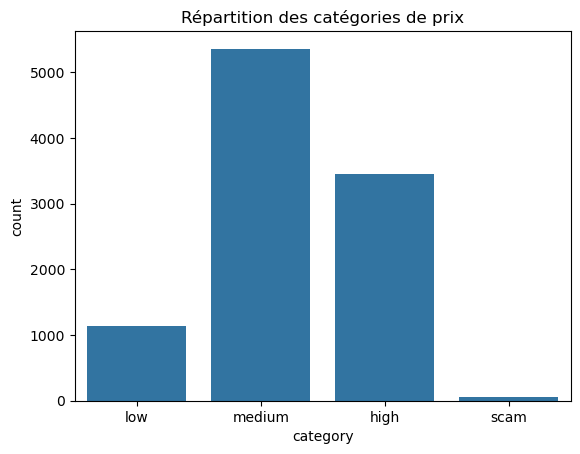

In [215]:
# Avec Matplop:
# Créer un Diagramme à barres pour afficher la répartition des catégories de prix 
# (par exemple, combien d'appartements sont "low", "normal", "high", "scam").

plt.figure()
sns.countplot(data=df, x='category', order=['low', 'medium', 'high', 'scam'])
plt.title("Répartition des catégories de prix")
plt.show()

### Bonus : HeatMap de correlation des prix par années de construction

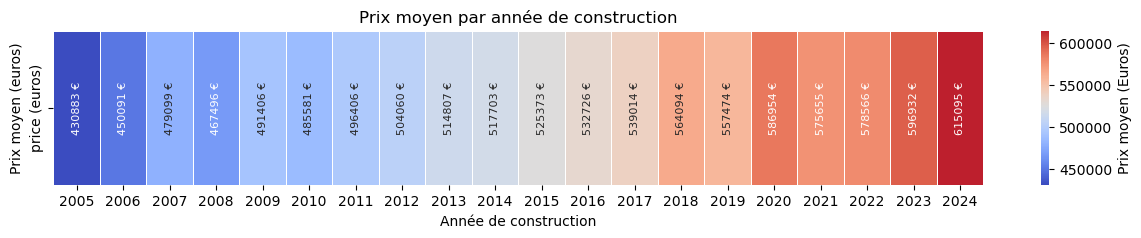

In [216]:
pivot_table = df.pivot_table(index='years_of_construction', values='price (euros)', aggfunc='mean')

pivot_table = pivot_table.transpose()

# Tracer la heatmap
plt.figure(figsize=(15, 2))
sns.heatmap(pivot_table, 
            cmap='coolwarm', 
            annot=pivot_table.map(lambda x: f"{int(x)} €"),
            fmt="", 
            cbar_kws={'label': 'Prix moyen (Euros)'}, 
            center=pivot_table.values.mean(), 
            linewidths=0.5,
            # orientation du texte vertical
            annot_kws={"rotation": 90, "fontsize": 8}
            )
plt.title('Prix moyen par année de construction')
plt.xlabel('Année de construction')
plt.ylabel('Prix moyen (euros)')
plt.show()

J'ai choisi ce format de heatmap qui est assez parlant en affichant une couleur de plus en plus chaude selon la valeur de la moyenne des prix par années.

Dans la génération du dataset j'applique une augmentation de 2% du prix par année. On le constate bien sur la heatmap.

### Bonus de bonus ... Divers essais

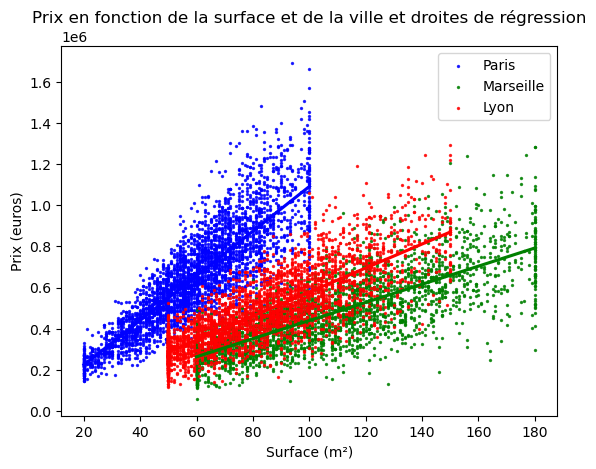

In [217]:
# Nuage de points des prix en fonction de la surface, en coloriant les points par ville

plt.figure()
sns.regplot(data=df[df['city'] == 'Paris'], x='area', y='price (euros)', scatter=True, scatter_kws={'s': 2}, color='blue', label='Paris', ci=None)
sns.regplot(data=df[df['city'] == 'Marseille'], x='area', y='price (euros)', scatter=True, scatter_kws={'s': 2}, color='green', label='Marseille', ci=None)
sns.regplot(data=df[df['city'] == 'Lyon'], x='area', y='price (euros)', scatter=True, scatter_kws={'s': 2}, color='red', label='Lyon', ci=None)
plt.legend()
plt.xlabel('Surface (m²)')
plt.ylabel('Prix (euros)')
plt.title('Prix en fonction de la surface et de la ville et droites de régression')
plt.show()

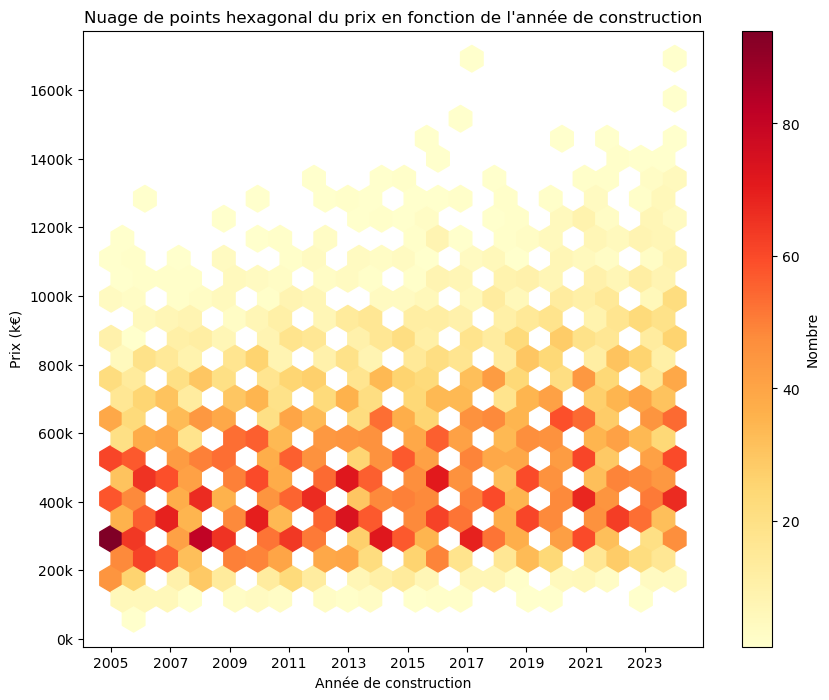

In [218]:
# Tentatives de diverses visualisations
# Nuage de points hexagonal du prix en fonction de l'année de construction

# Fonction pour formater les prix en milliers (k)
def price_in_thousands(x, pos):
    return f'{int(x/1000)}k'

plt.figure(figsize=(10, 8))

# Hexbin plot
plt.hexbin(df['years_of_construction'], df['price (euros)'], gridsize=25, cmap='YlOrRd', mincnt=1)
plt.colorbar(label='Nombre')

# Forcer l'affichage des années entières sur l'axe des x
plt.xticks(np.arange(int(df['years_of_construction'].min()), int(df['years_of_construction'].max()) + 1, 2))

# Appliquer le formateur de prix en milliers sur l'axe des y
plt.gca().yaxis.set_major_formatter(FuncFormatter(price_in_thousands))

plt.xlabel('Année de construction')
plt.ylabel('Prix (k€)')
plt.title('Nuage de points hexagonal du prix en fonction de l\'année de construction')
plt.show()


<Figure size 640x480 with 0 Axes>

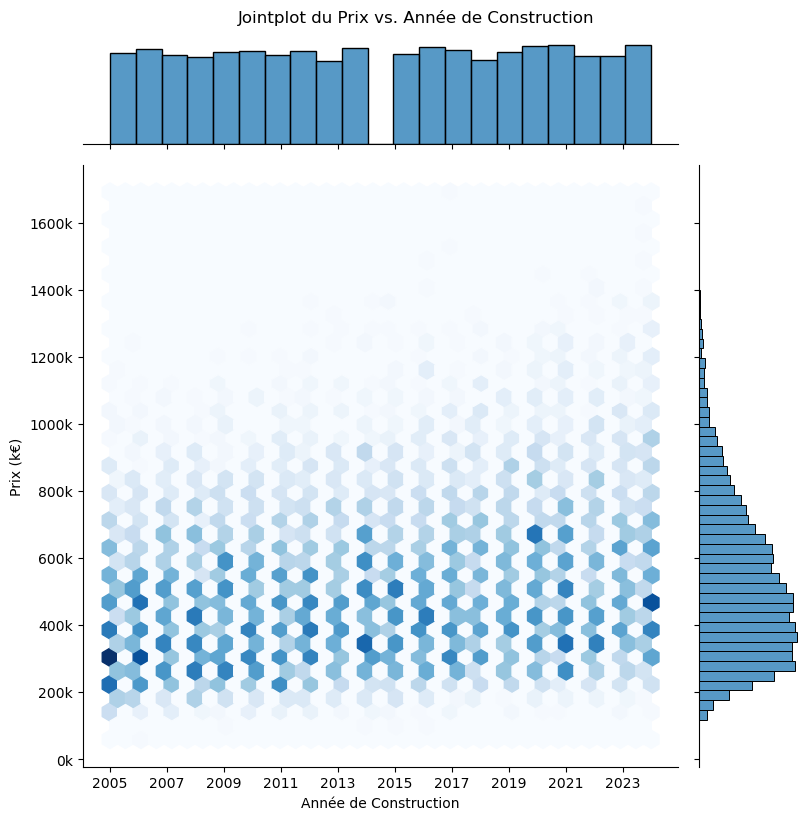

In [219]:
# jointplot
plt.figure()
sns.jointplot(x='years_of_construction', y='price (euros)', data=df, kind='hex', height=8, cmap='Blues')

# Fonction pour formater les prix en milliers (k)
def price_in_thousands(x, pos):
    return f'{int(x/1000)}k'

plt.gca().yaxis.set_major_formatter(FuncFormatter(price_in_thousands))
plt.xticks(np.arange(int(df['years_of_construction'].min()), int(df['years_of_construction'].max()) + 1, 2))

plt.suptitle('Jointplot du Prix vs. Année de Construction', y=1.02)
plt.xlabel('Année de Construction')
plt.ylabel('Prix (k€)')
plt.show()


## Prédictions

In [220]:
# importations
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [221]:
# Ajout de 3 colonnes au dataset (is_Paris, is_Lyon, is_Marseille) pour encoder la ville de chaque appartement

df['is_Paris'] = (df['city'] == 'Paris').astype(int)
df['is_Lyon'] = (df['city'] == 'Lyon').astype(int)
df['is_Marseille'] = (df['city'] == 'Marseille').astype(int)

df.head()

,city,price (euros),area,years_of_construction,number_of_rooms,have_balcony,have_garage,rating,category,is_Paris,is_Lyon,is_Marseille
0,Marseille,333332,68,2017,2,1,0,2.90,high,0,0,1
1,Lyon,490844,111,2014,3,1,1,4.80,low,0,1,0
2,Lyon,541000,98,2009,2,1,0,3.00,medium,0,1,0
3,Paris,658982,58,2017,1,0,0,3.50,high,1,0,0
4,Marseille,413818,107,2005,2,1,0,3.60,medium,0,0,1


### 2. Créer une prédiction par regression linéaire sur la note en fonction de la ville, de la surface et du prix

MSE: 0.24
               Coefficient
is_Paris              0.09
is_Lyon               0.13
is_Marseille         -0.22
area                  0.01
price (euros)         0.00


<Figure size 640x480 with 0 Axes>

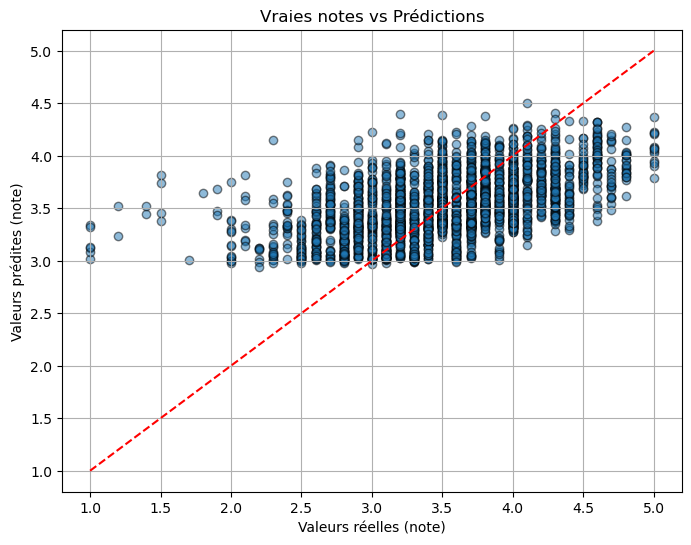

In [222]:
X = df[['is_Paris', 'is_Lyon', 'is_Marseille', 'area', 'price (euros)']]
y = df['rating']

# Séparer les données en training et testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Créer le modèle de régression linéaire
model = LinearRegression()

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédire les notes sur le jeu de test
y_pred = model.predict(X_test)

# Calculer l'erreur quadratique moyenne
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.2f}")

# Afficher les coefficients du modèle et l'erreur quadratique moyenne
model_coefficients = pd.DataFrame(model.coef_, index=X.columns, columns=['Coefficient'])
print(model_coefficients)

plt.figure()

# Afficher les prédictions par rapport aux vraies notes
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor='k')
plt.title('Valeurs réelles vs Valeurs prédites')
plt.xlabel('Valeurs réelles (note)')
plt.ylabel('Valeurs prédites (note)')
plt.grid(True)

# Afficher la droite d'identité
plt.plot([1, 5], [1, 5], color='red', linestyle='--')
plt.title('Vraies notes vs Prédictions')
plt.show()


On constate que les prédictions sont assez mauvaises. (Le dataset n'étant pas réaliste, c'est plutôt normal)

### 3. Créer une prédiction par regression linéaire sur l'année en fonction de la ville puis donner sa propabilité (R2) et son taux d'erreur en année (RSME ou MSE)

R²: -0.00
RMSE: 5.78 ans
MSE: 33.43 ans


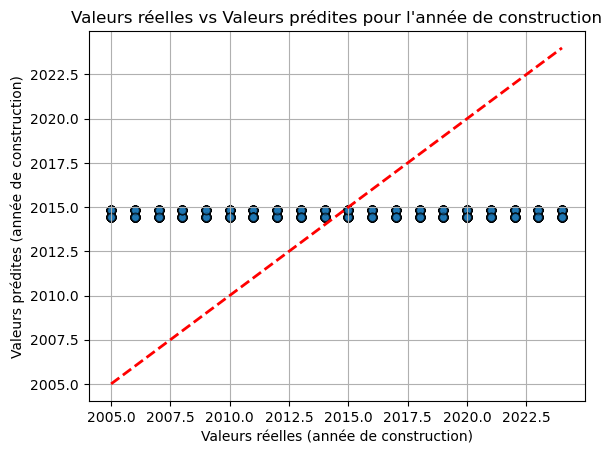

In [223]:
X = df[['is_Paris', 'is_Lyon', 'is_Marseille']]
y = df['years_of_construction']

# Séparer les données en training et testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Créer le modèle de régression linéaire
model = LinearRegression()

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédire les années de construction sur le jeu de test
y_pred = model.predict(X_test)

# Calculer le coefficient de détermination R2
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.2f}")

# Calcul de la RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f} ans")

# Calcul de la MSE 
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.2f} ans")

plt.figure()

# Afficher les prédictions par rapport aux vraies années de construction
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor='k')
plt.xlabel('Valeurs réelles (année de construction)')
plt.ylabel('Valeurs prédites (année de construction)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.title('Valeurs réelles vs Valeurs prédites pour l\'année de construction')
plt.grid(True)
plt.show()

R2 proche de 0 : la ville n'influance pas la date de construction des bâtiments
Ce graphique n'est pas parlant car les données ne sont pas réelles. La prédiction ne révèle aucun lien entre année de construction et ville.

### 4. Créer une classification logistique pour savoir si il y a un garage en fonction du prix et de la ville

Précision: 0.81
[[2317  120]
 [ 437  126]]
              precision    recall  f1-score   support

 Sans Garage       0.84      0.95      0.89      2437
 Avec Garage       0.51      0.22      0.31       563

    accuracy                           0.81      3000
   macro avg       0.68      0.59      0.60      3000
weighted avg       0.78      0.81      0.78      3000



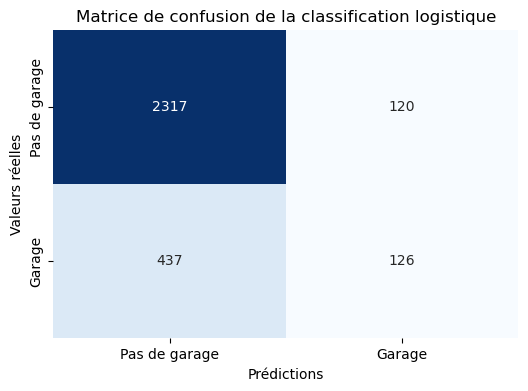

In [224]:
# Créer une classification logistique pour savoir si il y a un garage en fonction du prix et de la ville

X = df[['is_Paris', 'is_Lyon', 'is_Marseille', 'price (euros)']]
y = df['have_garage']

# Séparer les données en training et testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Créer le modèle de classification logistique
model = LogisticRegression(max_iter=1000)

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédire la présence de garage sur le jeu de test
y_pred_logistic = model.predict(X_test)

# Calculer l'accuracy
accuracy = accuracy_score(y_test, y_pred_logistic)
print(f"Précision: {accuracy:.2f}")

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_logistic)
print(conf_matrix)

report = classification_report(y_test, y_pred_logistic, target_names=['Sans Garage', 'Avec Garage'])
print(report)

# Heatmap pour la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Pas de garage", "Garage"], yticklabels=["Pas de garage", "Garage"])
plt.title("Matrice de confusion de la classification logistique")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.show()

Le modèle a du mal à prédir les cas où il y a bien un garage. Il y a beaucoup de faux négatifs.

### 5. Créer une classification par KNN pour savoir si il a un balcon en fonction du prix et de la ville

Précision: 0.51
[[900 721]
 [743 636]]
              precision    recall  f1-score   support

 Sans Balcon       0.55      0.56      0.55      1621
 Avec Balcon       0.47      0.46      0.46      1379

    accuracy                           0.51      3000
   macro avg       0.51      0.51      0.51      3000
weighted avg       0.51      0.51      0.51      3000



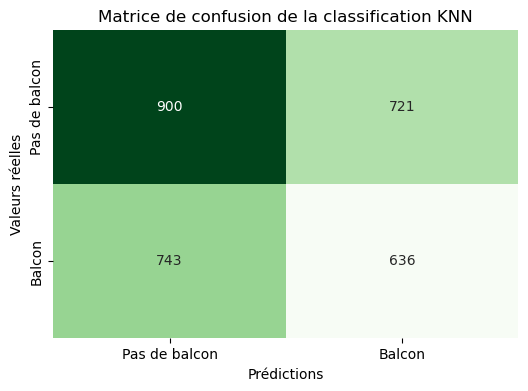

In [225]:
# 5. Créer une classification par KNN pour savoir si il a un balcon en fonction du prix et de la ville

X = df[['is_Paris', 'is_Lyon', 'is_Marseille', 'price (euros)']]
y = df['have_balcony']

# Séparer les données en training et testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Créer le modèle de classification KNN
model = KNeighborsClassifier(n_neighbors=5)

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédire la présence de balcon sur le jeu de test
y_pred_knn = model.predict(X_test)

# Calculer l'accuracy
accuracy = accuracy_score(y_test, y_pred_knn)
print(f"Précision: {accuracy:.2f}")

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_knn)
print(conf_matrix)

report = classification_report(y_test, y_pred_knn, target_names=['Sans Balcon', 'Avec Balcon'])
print(report)

# Créer une heatmap pour la matrice de confusion du modèle KNN
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", cbar=False, xticklabels=["Pas de balcon", "Balcon"], yticklabels=["Pas de balcon", "Balcon"])
plt.title("Matrice de confusion de la classification KNN")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.show()


### 7. Comparer les 2 méthodes de classification KNN et logistique précédente pour voir celle qui prédits le mieux: (accuracy, recall puis F1 Score)

In [226]:
report_logistic = classification_report(y_test, y_pred_logistic, target_names=['Sans Balcon', 'Avec Balcon'])
report_knn = classification_report(y_test, y_pred_knn, target_names=['Sans Balcon', 'Avec Balcon'])

print("Classification Logistique:")
print(report_logistic)
print("Classification KNN:")
print(report_knn)

Classification Logistique:
              precision    recall  f1-score   support

 Sans Balcon       0.56      0.96      0.71      1621
 Avec Balcon       0.74      0.13      0.22      1379

    accuracy                           0.58      3000
   macro avg       0.65      0.55      0.47      3000
weighted avg       0.64      0.58      0.49      3000

Classification KNN:
              precision    recall  f1-score   support

 Sans Balcon       0.55      0.56      0.55      1621
 Avec Balcon       0.47      0.46      0.46      1379

    accuracy                           0.51      3000
   macro avg       0.51      0.51      0.51      3000
weighted avg       0.51      0.51      0.51      3000



KNN est globalement meilleur en therme de recall et F1 score.

La régression logistique a une meilleure précision mais n'arrive pas à prédire les vrai positifs.

### 8. Créer une classification avec Random Forest (new algo) pour savoir si il y a un balcon en fonction du prix et de la ville 

Précision: 0.59
[[654 373]
 [452 521]]
              precision    recall  f1-score   support

 Sans Balcon       0.59      0.64      0.61      1027
 Avec Balcon       0.58      0.54      0.56       973

    accuracy                           0.59      2000
   macro avg       0.59      0.59      0.59      2000
weighted avg       0.59      0.59      0.59      2000



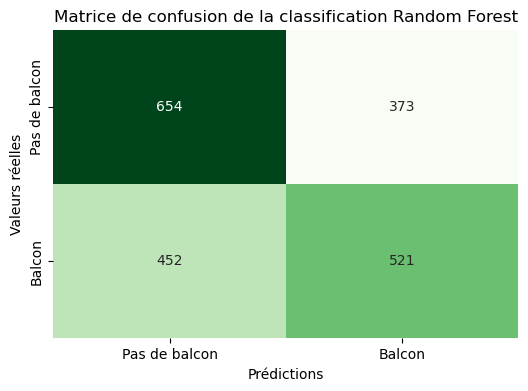

In [227]:
# Créer une classification avec Random Forest (new algo) pour savoir si il y a un balcon en fonction du prix et de la ville

X = df[['is_Paris', 'is_Lyon', 'is_Marseille', 'price (euros)']]
y = df['have_balcony']

# Séparer les données en training et testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Créer le modèle de classification Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=0)

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédire la présence de balcon sur le jeu de test
y_pred = model.predict(X_test)

# Calculer l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision: {accuracy:.2f}")

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

report = classification_report(y_test, y_pred, target_names=['Sans Balcon', 'Avec Balcon'])
print(report)

# Créer une heatmap pour la matrice de confusion du modèle Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", cbar=False, xticklabels=["Pas de balcon", "Balcon"], yticklabels=["Pas de balcon", "Balcon"])
plt.title("Matrice de confusion de la classification Random Forest")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.show()


Actuellement le meilleur modèle sur ce dataset.